# Calibration of models parameters: SPX
### based on One Touch Knock Out Daily Cliquet Options (expiration 6 months)

In [167]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')
import time

pd.reset_option('all')

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(110)

Let's initialize the values found in StockAnalysis module: scale factors for otko option prices and spx values.

In [168]:
spx_data = pd.read_csv('../../data/SPX/SPX_data.csv')
print(spx_data.head(6))

         Date         Open         High          Low        Close      Volume
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000
5  2016-01-27  1902.520020  1916.989990  1872.699951  1882.949951  4754040000


Let's retrieve the prices for One Touch Knock Out options on the SPX.

In [169]:
otko_spx = pd.read_csv('../../data/SPX/otko_prices_spx.csv')
print(f'Otko Prices: \n')
print(otko_spx.head())
SPX_S0 = spx_data.loc[spx_data['Date'] == '2016-01-20', 'Close'].values[0]
print(f'\n SPX Closing Value on 20/01/2016:', round(SPX_S0, 2))

Otko Prices: 

  Starting date Stock Name Expiry  K1  K2      BID      ASK
0    20/01/2016        SPX     6M  75   0  0.0850%  0.1000%
1    20/01/2016        SPX     6M  70   0  0.0400%  0.0500%
2    20/01/2016        SPX     6M  85  75  0.1700%  0.2000%
3    20/01/2016        SPX     6M  80  70  0.1200%  0.1400%
4    20/01/2016        SPX     6M  90  80  0.2400%  0.2700%

 SPX Closing Value on 20/01/2016: 1859.33


### Visualize payoffs of OTKO contracts

The BID(%) and ASK(%) prices are in percentages. This means that the protection buyer pays the $bid(%) * S0$ when acquiring the option, while the seller receives the $ask(%) * S0$.

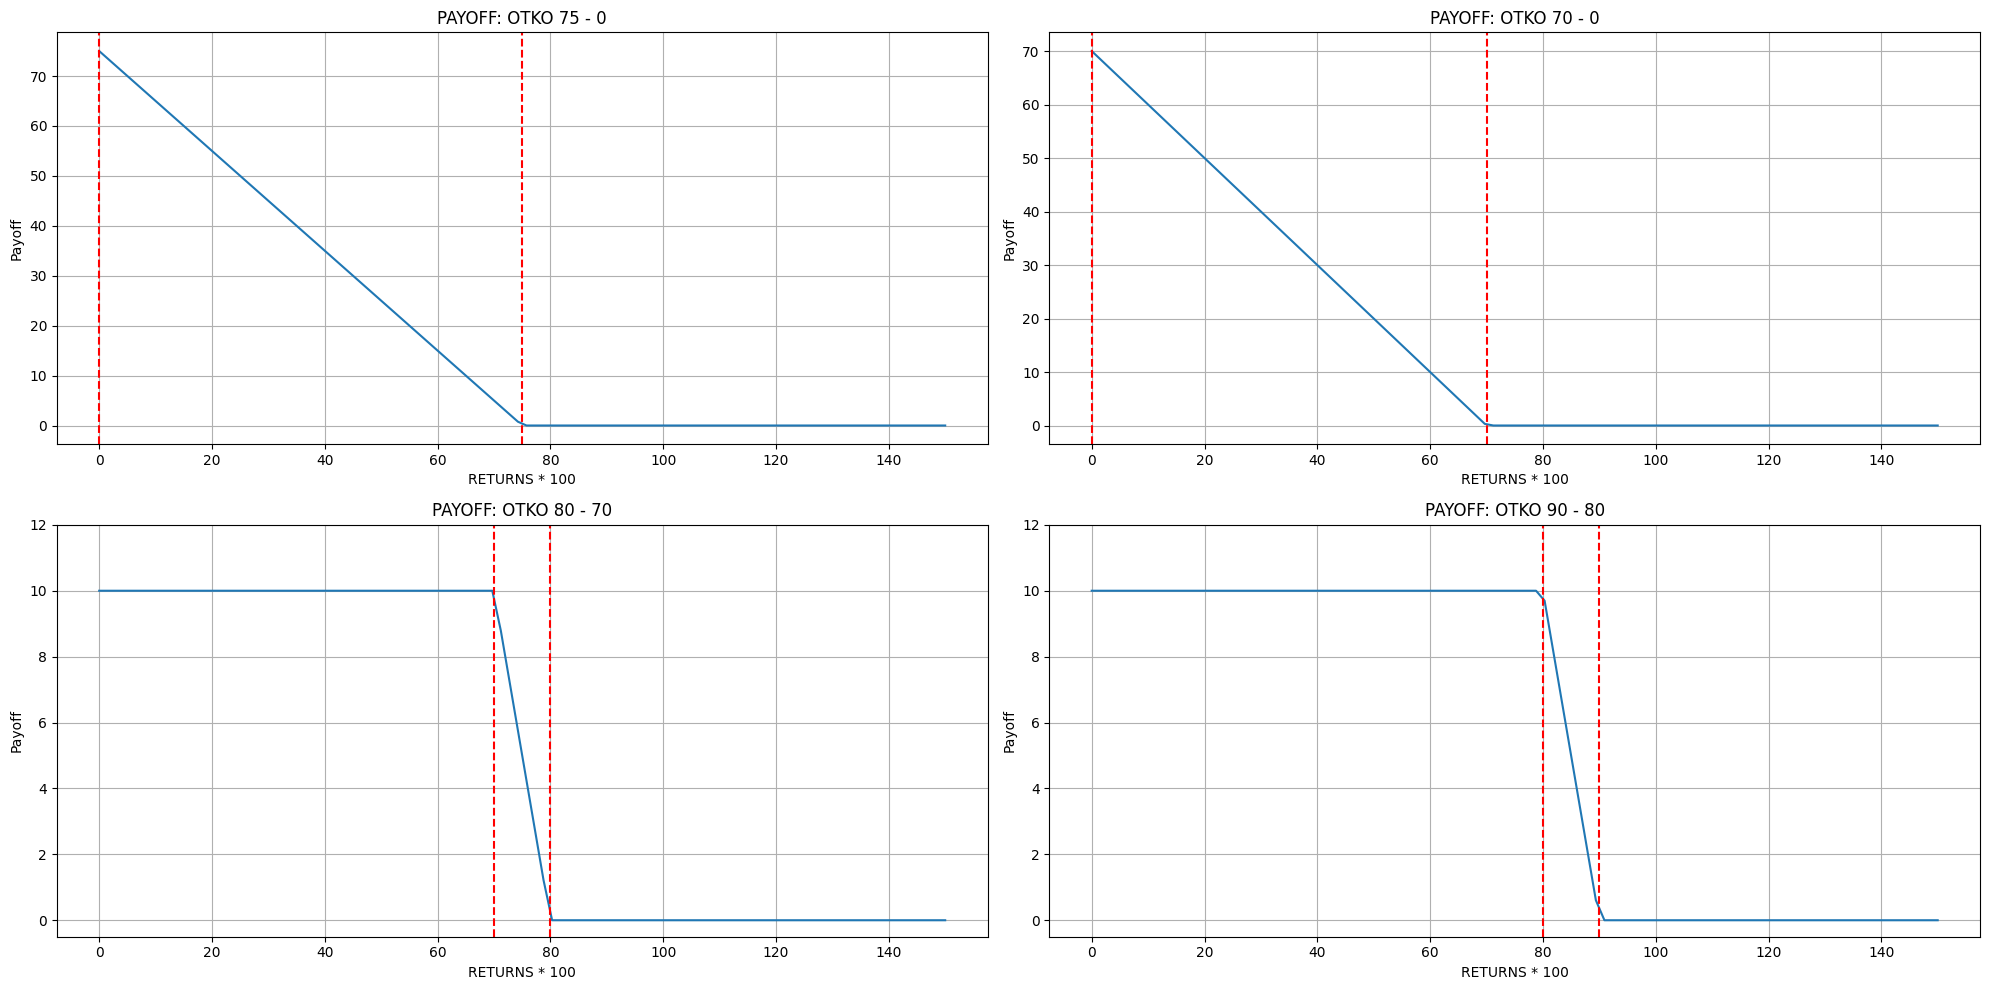

In [170]:
def otko_payoff(R, K1, K2):
    # R: Rendimento St/St-1 * 100
    # K2: Barriera di knock out
    # K1: Barriera di one touch
    # payoff_value: Valore del payoff quando l'opzione è attiva

    payoffs = []
    for Rt in R:
        if Rt > K1:
            payoffs.append(0)
        elif K2 < Rt <= K1:
            payoffs.append((K1 - Rt))
        elif Rt <= K2:
            payoffs.append((K1-K2))
    return payoffs

R = np.linspace(0,150,100)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
row = 0
col = 0

for index, contract in otko_spx.iterrows():
    if index != 2:  # Exclude the 2nd row (index 1)
        K1 = contract['K1']
        K2 = contract['K2']
        axes[row, col].plot(R, otko_payoff(R, K1, K2))
        axes[row, col].set_xlabel('RETURNS * 100')
        axes[row, col].set_ylabel('Payoff')
        axes[row, col].set_title(f'PAYOFF: OTKO {K1} - {K2}')
        if index != 0 and index!= 1:
            axes[row, col].set_ylim(-0.5, 12)
        axes[row, col].grid()
        # Add vertical lines for K1 and K2 (dashed)
        axes[row, col].axvline(x=K1, color='red', linestyle='--')
        axes[row, col].axvline(x=K2, color='red', linestyle='--')
        col += 1
        if col == 2:
            row += 1
            col = 0

plt.tight_layout()
plt.show()


#### Refactoring dataset

In [171]:
# Remove the percentage symbol and convert the columns to float
otko_spx['BID'] = otko_spx['BID'].str.rstrip('%').astype(float)
otko_spx['ASK'] = otko_spx['ASK'].str.rstrip('%').astype(float)

# Rename the columns
otko_spx.rename(columns={'BID': 'BID(%)', 'ASK': 'ASK(%)'}, inplace=True)

otko_spx['Midpoint(%)'] = otko_spx['BID(%)'] + (abs(otko_spx['BID(%)'] - otko_spx['ASK(%)']) / 2)

#otko_spx.to_csv('../../data/SPX/otko_spx_6m.csv')
print(otko_spx)

  Starting date Stock Name Expiry  K1  K2  BID(%)  ASK(%)  Midpoint(%)
0    20/01/2016        SPX     6M  75   0   0.085    0.10       0.0925
1    20/01/2016        SPX     6M  70   0   0.040    0.05       0.0450
2    20/01/2016        SPX     6M  85  75   0.170    0.20       0.1850
3    20/01/2016        SPX     6M  80  70   0.120    0.14       0.1300
4    20/01/2016        SPX     6M  90  80   0.240    0.27       0.2550


## One Touch Knock Out daily Cliquets Option Pricing

In [172]:
S0 = spx_data.loc[0, 'Close']
r = 0.05
T = 0.5
q = 0
exercise = 'european'
symbol = 'SPX'
paths = 1000
days = 126

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint(%)']
})

th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

strikes = otko_spx[['K1', 'K2']].values / 100

### Calibration of model parameters
The following code snippet perfoms calibration of the models parameters using closed forms.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i },$$ $P_i$ are the market prices and $f$ is the pricing function, $f$ given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. The optimization problem is carried out using the module *least_squares* of the library `scipy.optimize`.
Let's define the spread first.

In [173]:
# BOOK:  Financial modelling with jump processes  PAG 442
weights =  1/(otko_spx['ASK(%)'] - otko_spx['BID(%)'])**2
mkt_prices = otko_spx['Midpoint(%)'].values

#### Merton Jump Diffusion

In [174]:
x0 = [0.1336, 0.3, -0.5, 0.1]       # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [2, 2, 0, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err +=  weights[k]*(M.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices), bounds=bounds, method = 'trf', verbose=1)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 6.9251e+08, final cost 9.9503e-04, first-order optimality 2.64e-03.


In [175]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1336 	 13.36%
> Calibrated Jump intensity [λ] =  0.11
> Calibrated Jump Mean =  -0.152
> Calibrated Jump St. dev.  =  0.186
TIME ELAPSED:  1.81 sec


In [176]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> OTKO DC:\t\t\t {mert_params_calibrated}')

CALIBRATED PARAMETERS [σ		λ		m		v]
> OTKO DC:			 [0.1336, 0.1101, -0.1515, 0.1863]


##### Visualize paths with the calibrated parameters

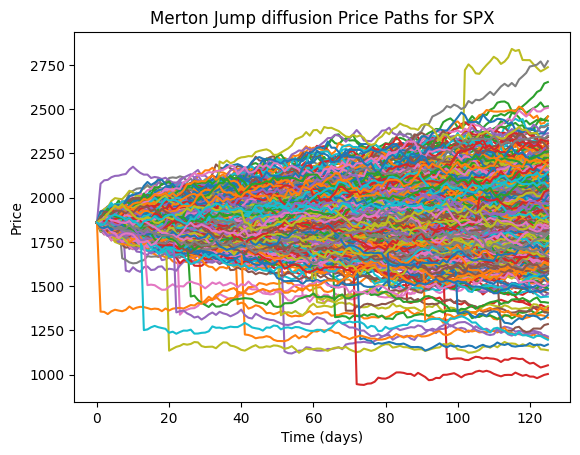

<Figure size 1000x600 with 0 Axes>

In [177]:
sigma_c, lambd_c, meanJ_c, stdJ_c = mert_params_calibrated
MERT_CAL = Merton_pricer(S0, None, T, r, q, sigma_c, lambd_c, meanJ_c, stdJ_c, exercise)
SMerton_CAL = MERT_CAL.MertonPath(days, paths)
MERT_CAL.plotMertonPath(SMerton_CAL, symbol)  # Plot all paths

#### Kou Jump diffusion model

In [178]:
x0 =  [0.125, 0.44, 0.5, 10.3, 7.5]    # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [2, 10, 1, 20, 50] )

# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err += weights*(KOU.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end2=time.time()

kou_params_calibrated = [round(p,4) for p in kou2.x[:5]]

`ftol` termination condition is satisfied.
Function evaluations 266, initial cost 1.0029e+03, final cost 4.2978e+01, first-order optimality 9.01e-01.


In [179]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.125 	 12.5%
> Calibrated Jump intensity [λ] =  0.4
> Calibrated Upward Jump probability [p] = 0.57, [q] = 0.43
> Calibrated Rate of Exp. 1  [η_1] =  10.3
> Calibrated Rate of Exp. 2  [η_2] =  7.09
TIME ELAPSED:  0.61 sec


In [180]:
print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> OTKO DC:\t\t\t {kou_params_calibrated}')

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> OTKO DC:			 [0.125, 0.3984, 0.5652, 10.3, 7.0866]


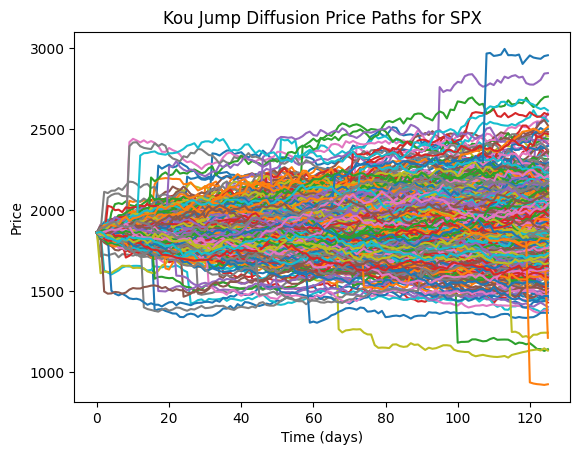

<Figure size 1000x600 with 0 Axes>

In [181]:
sigma, lambd, p, eta1, eta2 = kou_params_calibrated
KOU_CAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
#KOU = Kou_pricer(S0, None, T, r, 0.23, 7.04, 0.985,0.0765,0.0414, S0)

SKou_cal = KOU_CAL.KouPath(days, paths)
# Plot all paths
KOU_CAL.plotKouPath(SKou_cal, symbol)

#### Variance Gamma process model

In [182]:
x0 =[0.3034, -0.75, 1.1941]  # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [0.6, 2, 4] )

def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    sq_err = 0
    for k in [0,1,2,3,4]:
        sq_err += weights*(VG.closed_formula_otko6(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 9.5429e+11, final cost 1.6914e+04, first-order optimality 5.32e+04.


In [183]:
print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2026, 	 20.26%
> Calibrated mean rate gamma process [θ] =  0.1338
> Calibrated variance rate gamma process [v]=  1.4129
TIME ELAPSED:  0.61 sec


In [184]:
print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> OTKO DC:\t\t\t {vg_params_calibrated}')

CALIBRATED PARAMETERS: [σ 		θ		 v]
> OTKO DC:			 [0.2026, 0.1338, 1.4129]


VG as Time changed brownian Motion. Parameters: 
> Sigma = 0.2026
> Theta = 0.1338
> Nu = 1.4129
VG as Time difference of gammas. Parameters: 
> Mean Upward Jumps = 0.205
> Variance Downward Jumps = 0.059
> Variance Upward Jumps = 0.071
> Variance Downward Jumps = 0.007


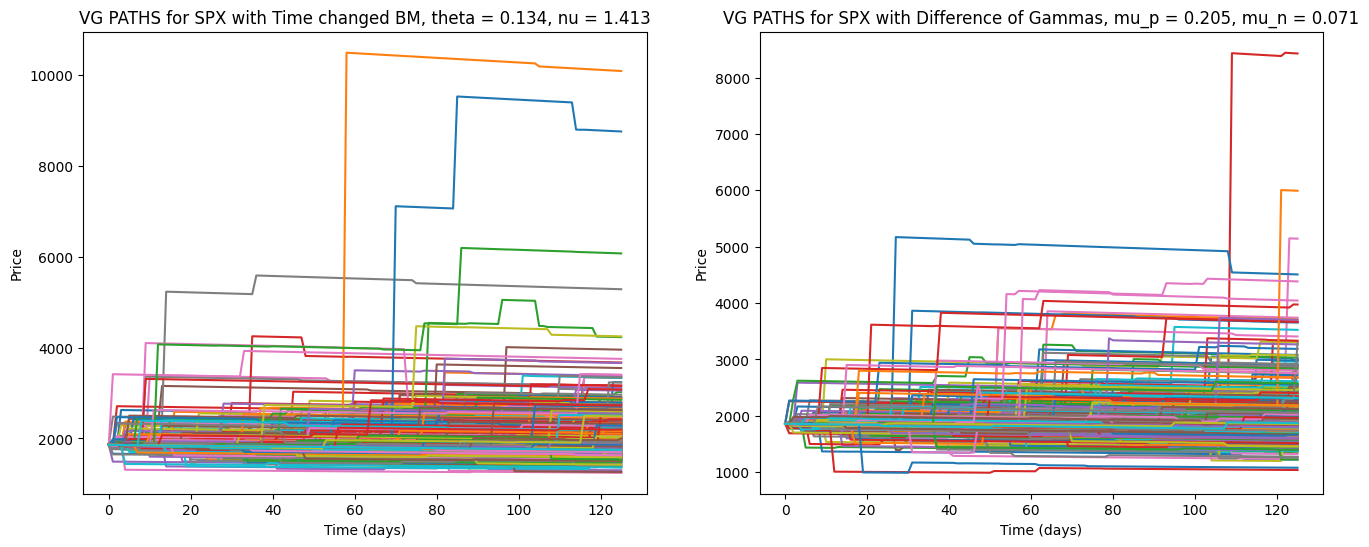

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [185]:
sigma, theta, nu = vg_params_calibrated

VG_CAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_cal = VG_CAL.VarianceGammaPath1(days, paths)
SVarGamma2_cal = VG_CAL.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG_CAL.plotVGPath(SVarGamma_cal, symbol, method[0], ax=axes[0])
VG_CAL.plotVGPath(SVarGamma2_cal, symbol, method[1], ax=axes[1])
plt.tight_layout()

print('VG as Time changed brownian Motion. Parameters: ')
print(f'> Sigma = {sigma}\n> Theta = {theta}\n> Nu = {nu}')
print('VG as Time difference of gammas. Parameters: ')
print(f'> Mean Upward Jumps = {round(VG_CAL.get_mu_p,3)}\n> Variance Downward Jumps = {round(VG_CAL.get_nu_p,3)}')
print(f'> Variance Upward Jumps = {round(VG_CAL.get_mu_n,3)}\n> Variance Downward Jumps = {round(VG_CAL.get_nu_n,3)}')

### Option pricing with calibrated parameters
The following code snippet aims to find both Monte Carlo and Closed Formulas option prices for our **OTKO Daily Cliquet**.

In [186]:
calibrated_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'MKT_BID (%)': otko_spx['BID(%)'],
    'MKT_MID (%)': otko_spx['Midpoint(%)'],
    'MKT_ASK (%)': otko_spx['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 6 MONTHS. \n\n{calibrated_prices}')


MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 6 MONTHS. 

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0        0.085       0.0925         0.10
1  70   0        0.040       0.0450         0.05
2  85  75        0.170       0.1850         0.20
3  80  70        0.120       0.1300         0.14
4  90  80        0.240       0.2550         0.27


#### Merton Jump diffusion

In [187]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton_CAL.T:
        payoffs.append(MERT_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calibrated_prices))
merton_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = MERT_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['MERTON MC (%)'] = [round(p,2) for p in merton_mc_prices]
calibrated_prices['MERTON CF (%)'] = [round(p,2) for p in merton_cf_prices]


#### Kou Jump Diffusion

In [188]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou_cal.T:
        payoffs.append(KOU_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calibrated_prices))
kou_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = KOU_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['KOU MC (%)'] = [round(p,2) for p in kou_mc_prices]
calibrated_prices['KOU CF (%)'] = [round(p,2) for p in kou_cf_prices]

#### Variance Gamma

In [189]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma_cal.T:
        payoffs.append(VG_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(calibrated_prices))
vg_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG_CAL.closed_formula_otko6(strikes[index][0], strikes[index][1])

calibrated_prices['VG MC (%)'] = [round(p,3) for p in vg_mc_prices]
calibrated_prices['VG CF (%)'] = [round(p,3) for p in vg_cf_prices]

In [190]:
print(calibrated_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)   
0  75   0        0.085       0.0925         0.10           0.09  \
1  70   0        0.040       0.0450         0.05           0.04   
2  85  75        0.170       0.1850         0.20           0.22   
3  80  70        0.120       0.1300         0.14           0.14   
4  90  80        0.240       0.2550         0.27           0.30   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0           0.09        0.05        0.10      0.021      0.030  
1           0.04        0.03        0.06      0.000      0.012  
2           0.19        0.15        0.17      0.185      0.139  
3           0.13        0.07        0.11      0.084      0.060  
4           0.25        0.27        0.27      0.339      0.320  


### Calibration using Monte Carlo prices and matrices
In order to calibrate parameters without using any python library, a sort of **manual** calibration can be performed. To do so,a $(n+1)$-dimensional matrix is built, where n is the number of the parameters for each model. The $(n+1)-th$ dimension is needed to address the different strike couples.
#### Merton Jump Diffusion Monte Carlo Calibration

#### Kou Jump Diffusion Monte Carlo calibration

#### Variance Gamma process Monte Carlo Calibration


### VISUALIZE RESULTS